Pour ce projet, nous avons suivi le schéma présenté dans cet article:
https://towardsdatascience.com/a-complete-machine-learning-walk-through-in-python-part-one-c62152f39420

## 1.1 - Imports


In [1]:
import mlflow
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, roc_auc_score, f1_score, fbeta_score, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler


from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

import lightgbm as lgb

from mlflow.models import infer_signature
from lightgbm import early_stopping

import shap
# Memory management
import gc 

In [2]:
train_reduced=pd.read_csv('train_reduced.csv')

In [3]:
train_reduced.head()

,CREDIT_TERM,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_EMPLOYED,DAYS_BIRTH,client_installments_AMT_PAYMENT_min_sum,AMT_ANNUITY,bureau_DAYS_CREDIT_ENDDATE_max,bureau_DAYS_CREDIT_max,...,client_bureau_balance_STATUS_X_count_min,previous_NAME_CASH_LOAN_PURPOSE_XAP_sum,client_bureau_balance_STATUS_X_count_norm_sum,client_installments_NUM_INSTALMENT_NUMBER_min_max,client_credit_AMT_INST_MIN_REGULARITY_sum_mean,OCCUPATION_TYPE_Laborers,previous_NAME_SELLER_INDUSTRY_Construction_mean,previous_NAME_CASH_LOAN_PURPOSE_XNA_sum,TARGET,SK_ID_CURR
0,0.060749,0.083037,0.262949,0.139376,-637.0,9461,175783.73,24700.5,780.0,-103.0,...,0.0,1.0,1.295454,1.0,NaN,True,0.000000,0.0,True,100002
1,0.027598,0.311267,0.622246,NaN,-1188.0,16765,1154108.20,35698.5,1216.0,-606.0,...,NaN,2.0,0.000000,1.0,NaN,False,0.000000,1.0,False,100003
2,0.050000,NaN,0.555912,0.729567,-225.0,19046,16071.75,6750.0,-382.0,-408.0,...,NaN,1.0,0.000000,1.0,NaN,True,0.000000,0.0,False,100004
3,0.094941,NaN,0.650442,NaN,-3039.0,19005,994476.70,29686.5,NaN,NaN,...,NaN,4.0,NaN,1.0,0.0,True,0.111111,5.0,False,100006
4,0.042623,NaN,0.322738,NaN,-3038.0,19932,483756.38,21865.5,-783.0,-1149.0,...,NaN,2.0,0.000000,1.0,NaN,False,0.000000,4.0,False,100007


In [4]:
train_reduced.shape

(307511, 339)

# 5 - Nouvelle modélisation LGBM avec features = 95% de l'importance

In [5]:
# train_reduced_origin=train_reduced.copy()

In [6]:
# extract IDs
id_r = train_reduced['SK_ID_CURR']
        
# Extract the labels for training
y_r = train_reduced['TARGET']
    
# Remove the ids and target
X_r = train_reduced.drop(['SK_ID_CURR','TARGET'], axis=1)  
    

In [7]:
def prepare_modelisation (X,y) :

    # split train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Create a label encoder object
    le = LabelEncoder()
    
    # Iterate through the columns and label encode if object type and nunique <=2
    for col in X_train.columns:
        if X_train[col].dtype == 'object' and len(list(X_train[col].unique())) <= 2:
            # Apply the label encoder to both training and test sets
            X_train[col] = le.fit_transform(X_train[col])
            X_test[col] = le.transform(X_test[col])

               
    # one-hot encoding of categorical variables
    X_train = pd.get_dummies(X_train)
    X_test = pd.get_dummies(X_test)

    # Assurons-nous que X_train et X_test ont les mêmes colonnes
    X_train, X_test = X_train.align(X_test, join='inner', axis=1)
    
   
    # Median imputation of missing values
    imputer = SimpleImputer(strategy = 'median')

    # Scale each feature to 0-1
    scaler = MinMaxScaler(feature_range = (0, 1))

    X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
    X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

   
    return X_train, X_test, y_train, y_test

In [8]:
X_train_r, X_test_r, y_train_r, y_test_r=prepare_modelisation (X_r,y_r)

In [9]:
X_train_r.head(1)

,CREDIT_TERM,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_EMPLOYED,DAYS_BIRTH,client_installments_AMT_PAYMENT_min_sum,AMT_ANNUITY,bureau_DAYS_CREDIT_ENDDATE_max,bureau_DAYS_CREDIT_max,...,client_bureau_balance_STATUS_1_count_norm_max,client_cash_CNT_INSTALMENT_min_min,client_bureau_balance_STATUS_X_count_min,previous_NAME_CASH_LOAN_PURPOSE_XAP_sum,client_bureau_balance_STATUS_X_count_norm_sum,client_installments_NUM_INSTALMENT_NUMBER_min_max,client_credit_AMT_INST_MIN_REGULARITY_sum_mean,OCCUPATION_TYPE_Laborers,previous_NAME_SELLER_INDUSTRY_Construction_mean,previous_NAME_CASH_LOAN_PURPOSE_XNA_sum
0,0.072317,0.544382,0.419378,0.629055,0.908106,0.894025,0.098148,0.057529,0.583347,0.795003,...,0.038462,0.070423,0.0,0.076923,0.100092,0.068702,0.224543,0.0,0.0,0.051724


In [10]:
X_train_r.shape, X_test_r.shape, y_train_r.shape, y_test_r.shape

((246008, 337), (61503, 337), (246008,), (61503,))

# **FONCTION DU NB 1 A SUPPRIMER QUAND ON GROUPERA LES NB**

In [11]:
def custom_f1(y_true, y_pred_proba):
    thresholds = np.linspace(0, 1, 100)
    best_threshold = 0.5
    best_f1 = 0
    best_cost = float('inf')
    
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        f1 = f1_score(y_true, y_pred)
        # Calculer les coûts
        fn = np.sum((y_true == 1) & (y_pred == 0))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        cost = fn * 10 + fp
        
        # Sélectionner le seuil basé sur le coût le plus bas
        if cost < best_cost:
            best_f1 = f1
            best_threshold = threshold
            best_cost = cost
    
    return best_f1

In [12]:


def custom_recall(y_true, y_pred_proba):
    thresholds = np.linspace(0, 1, 100)
    best_threshold = 0.5
    best_recall = 0
    best_cost = float('inf')
    
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        recall = recall_score(y_true, y_pred)
        # Calculer les coûts
        fn = np.sum((y_true == 1) & (y_pred == 0))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        cost = fn * 10 + fp
        
        # Sélectionner le seuil basé sur le coût le plus bas
        if cost < best_cost:
            best_recall = recall
            best_threshold = threshold
            best_cost = cost
    
    return best_recall

In [13]:
# Fonction pour run la grid search. J'y ajoute le fit_params dans le quel j'ajouterai l'early stopping pour le lgbm

def run_grid_search(X_train, y_train, model, param_grid, fit_params=None, train_size=1.0):
    # Définir les scorers personnalisés
    scorers = {
        'AUC': 'roc_auc',
        'F1_opt': make_scorer(custom_f1, needs_proba=True),
        'recall_opt': make_scorer(custom_recall, needs_proba=True)
    }

    # Créer un pipeline avec SMOTE et le modèle
    pipeline = Pipeline([
        ('sampling', SMOTE(random_state=42)),
        ('model', model)
    ])

    # Mettre à jour le param_grid pour correspondre au pipeline
    # Les paramètres du modèle doivent être préfixés par 'model__'
    param_grid = {f'model__{key}': value for key, value in param_grid.items()}

    grid_search = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        scoring=scorers,
        refit='AUC',
        cv=2,
        verbose=3,
        return_train_score=True
    )

     # Fractionnement des données si train_size < 1.0
    if train_size < 1.0:
        X_train_sample, _, y_train_sample, _ = train_test_split(X_train, y_train, train_size=train_size, random_state=42)
        data_to_fit = (X_train_sample, y_train_sample)
    else:
        data_to_fit = (X_train, y_train)

    # Entraînement
    start_time = time.time()
    grid_search.fit(*data_to_fit)
    end_time = time.time()

    execution_time = round(end_time - start_time, 2)
    print(f"Le temps d'execution est de {execution_time} secondes.")

    return {
        'best_model' : grid_search.best_estimator_,
        'best_params_': grid_search.best_params_,
        'best_score_': grid_search.best_score_,
        'cv_results_': grid_search.cv_results_
    }

In [14]:
def extract_best_auc_result(results):
    """
    Extracts the best model configuration based on AUC score from the cv_results of a GridSearchCV.
    
    Parameters:
    - results (dict): A dictionary output from the run_grid_search function containing 'cv_results_'.
    
    Returns:
    - DataFrame: A DataFrame containing the best scoring row based on the AUC rank.
    """
    # Conversion of cv_results_ into a DataFrame
    cv_results = results['cv_results_']
    df_cv_results = pd.DataFrame(cv_results)
    
    # Sorting the DataFrame by the rank of the AUC test scores
    df_cv_results = df_cv_results.sort_values(by="rank_test_AUC", ascending=True)
    
    # Returning the top entry
    return df_cv_results.head(1)

In [15]:
def plot_auc_scores(best_auc_result):
    """
    Plots the AUC scores from cross-validation folds for the best model configuration based on rank.
    
    Parameters:
    - best_auc_result (DataFrame): A DataFrame with the top row from cv_results_ sorted by AUC.
    - full_cv_results (DataFrame): The full cv_results DataFrame to extract mean scores for rank 1.
    """
    # Extract the AUC scores for each fold for the best AUC configuration
    df_train_results_auc = best_auc_result[[
        'split0_train_AUC', 
        'split1_train_AUC', 
        # 'split2_test_AUC', 
        # 'split3_test_AUC', 
        # 'split4_test_AUC'
    ]][best_auc_result['rank_test_AUC'] == 1].values
    
    df_test_results_auc = best_auc_result[[
        'split0_test_AUC', 
        'split1_test_AUC', 
        # 'split2_test_AUC', 
        # 'split3_test_AUC', 
        # 'split4_test_AUC'
    ]][best_auc_result['rank_test_AUC'] == 1].values
    
    fig, ax = plt.subplots(figsize=(8, 4))
    
    # Plot the train scores
    ax.plot(range(0, 2), df_test_results_auc.reshape(-1), label='Scores de validation')
    
    # Plot the test scores
    ax.plot(range(0, 2), df_train_results_auc.reshape(-1), label='Scores de train')

    # # Plot the average for the combinations with rank_test_AUC == 1
    # mean_scores_rank_1 = best_auc_result.loc[best_auc_result['rank_test_AUC'] == 1, 'mean_test_AUC']
    # ax.axhline(y=mean_scores_rank_1.values[0], color='g', linestyle='--', label='Moyenne (rank 1)')
    
    # Set the properties of the axis
    ax.set_xticks(range(0, 2))
    ax.set_xlabel("Folds de cross-validation")
    ax.set_ylabel('AUC')
    ax.set_title("AUC de chaque fold \n pour la combinaison d'hyperparamètres \n qui arrive au rang 1 en terme d'AUC", fontsize=15, weight="bold", fontname="Impact", color="#0e2452")
    
    # Add a legend
    ax.legend()

    fig.tight_layout()
    
    plt.show()


In [16]:
# fonction qui va établir un seuil pour convertir les probabiliiéts en étiquettes de classe binaire. 
# à partir de la matrice de confusion, on va calculer le coût

def calculate_cost_threshold(y_true, probas, threshold, cost_fn, cost_fp):
    y_pred = (probas >= threshold).astype(int) # transforme les probas en prédictions binaires en utilisant un seuil. 
                                                # Les probabilités >= au seuil sont marquées comme 1 (positives),
                                                # les autres comme 0 (négatives).

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel() # .ravel() convertit la matrice 2x2 en un tableau à une dimension [tn, fp, fn, tp]
                                                            # permet une extraction facile de chaque valeur
    return cost_fn * fn + cost_fp * fp

In [17]:
def evaluate_model (X_train, y_train, X_test, y_test, best_model):

    start_predict_time = time.time()
    # Predict on the training data
    y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]
    
    # Predict on the test data
    y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]

    end_predict_time = time.time()

    # Calculate AUC for training and test data
    auc_train = round(roc_auc_score(y_train, y_train_pred_proba),2)
    auc_test = round(roc_auc_score(y_test, y_test_pred_proba),2)

    # Find the optimal threshold for cost function on the training data
    thresholds = np.linspace(0, 1, 100)
    costs = [calculate_cost_threshold(y_test, y_test_pred_proba, thr, cost_fn=10, cost_fp=1) for thr in thresholds]
    optimal_threshold = round(thresholds[np.argmin(costs)],2) 

    # Metrics at the optimal threshold
    y_test_pred_opt = (y_test_pred_proba >= optimal_threshold).astype(int)
    
    f1_score_1_test = f1_score(y_test, y_test_pred_opt)
    recall_1_test = recall_score(y_test, y_test_pred_opt)
    accuracy_test = accuracy_score(y_test, y_test_pred_opt)
    
    return {
        'predicting_execution_time': round(end_predict_time - start_predict_time, 2),
        'auc_train': auc_train,
        'auc_test': auc_test,
        'optimal_threshold': optimal_threshold,
        'f1_score_1_test': round(f1_score_1_test,2),
        'recall_1_test': round(recall_1_test,2),
        'accuracy_test': round(accuracy_test,2)
    }

In [18]:
def show_feature_importances(importances, features):
    # Création du DataFrame

    importances = importances.flatten()
    
    feature_importances = pd.DataFrame({
        'feature': features, 
        'importance': importances
    })
    
    # Tri et sélection des 10 caractéristiques les plus importantes
    feature_importances_sorted = feature_importances.sort_values(by='importance', ascending=False).reset_index(drop=True)
    feature_importances_sorted = feature_importances_sorted.head(10)
    
    # Normalisation des importances
    feature_importances_sorted['importance_normalized'] = feature_importances_sorted['importance'] / feature_importances_sorted['importance'].sum()
    
    # Création du graphique à barres horizontales
    plt.figure(figsize=(10, 6))
    ax = plt.subplot()
    
    # Inversion de l'index pour afficher la plus importante en haut
    indices = list(reversed(list(feature_importances_sorted.index)))
    ax.barh(indices, feature_importances_sorted['importance_normalized'], align='center', edgecolor='k')
    
    # Définition des étiquettes y
    ax.set_yticks(indices)
    ax.set_yticklabels(feature_importances_sorted['feature'])
    
    # Étiquetage du graphique
    plt.xlabel('Normalized Importance')
    plt.title('Top 10 Feature Importances')
    plt.show()
    
    return feature_importances_sorted

# Exemple d'utilisation
# importances = [valeur1, valeur2, ..., valeurN] # remplacez par vos valeurs d'importance réelles
# features = ['nom1', 'nom2', ..., 'nomN'] # remplacez par vos noms de caractéristiques réels
# feature_importances_sorted = plot_feature_importances(importances, features)


# **FIN DES FONCTIONS DU NB 1 A SUPPRIMER QUAND ON GROUPERA LES NB**

In [19]:
model_LGBM_2 = lgb.LGBMClassifier(objective='binary',
                                boosting_type = 'goss',
                                # class_weight = 'balanced',
                                random_state = 50)
        
param_grid_LGBM_2 = {
    'num_leaves': [35,40],
    'n_estimators' : [150,200],   
    'learning_rate' : [0.07, 0.1],
}

# Paramètres pour early_stopping
fit_params = {
    'eval_metric': 'auc',
    'callbacks':[early_stopping(stopping_rounds=50)]
}

In [20]:
# Execution de la fonction
start_training_time = time.time()

results_LGBM_2 = run_grid_search(X_train_r, y_train_r, model_LGBM_2, param_grid_LGBM_2,fit_params)

end_training_time = time.time()

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 113066, number of negative: 113066
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.340423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85806
[LightGBM] [Info] Number of data points in the train set: 226132, number of used features: 337
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore

In [21]:
training_execution_time = round(end_training_time - start_training_time,2)  
print(f"Le temps d'exécution est de {training_execution_time} secondes.")

Le temps d'exécution est de 418.21 secondes.


In [22]:
best_model_lgbm_2 = results_LGBM_2['best_model']
best_params_lgbm_2 = results_LGBM_2['best_params_']
best_score_lgbm_2 = results_LGBM_2['best_score_']
cv_results_lgbm_2 = results_LGBM_2['cv_results_']

print("Best Params:", best_params_lgbm_2)
print("Best AUC:", best_score_lgbm_2)

Best Params: {'model__learning_rate': 0.07, 'model__n_estimators': 200, 'model__num_leaves': 35}
Best AUC: 0.767329732651925


In [23]:
best_auc_result_LGBM_2 = extract_best_auc_result(results_LGBM_2)
best_auc_result_LGBM_2.head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__learning_rate,param_model__n_estimators,param_model__num_leaves,params,split0_test_AUC,split1_test_AUC,...,std_train_F1_opt,split0_test_recall_opt,split1_test_recall_opt,mean_test_recall_opt,std_test_recall_opt,rank_test_recall_opt,split0_train_recall_opt,split1_train_recall_opt,mean_train_recall_opt,std_train_recall_opt
2,14.872857,0.252497,4.364253,0.081625,0.07,200,35,"{'model__learning_rate': 0.07, 'model__n_estim...",0.76696,0.7677,...,0.000759,0.646408,0.685852,0.66613,0.019722,6,0.761924,0.760213,0.761069,0.000855


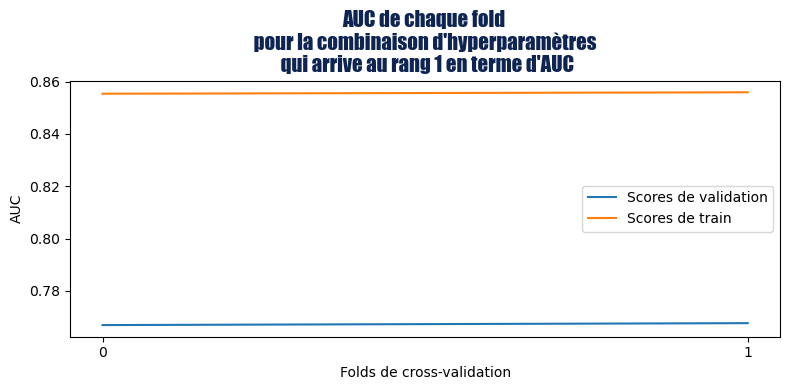

In [24]:
plot_auc_scores(best_auc_result_LGBM_2)

In [25]:
result_lgbm_2=evaluate_model (X_train_r, y_train_r, X_test_r, y_test_r, best_model_lgbm_2)
result_lgbm_2

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


{'predicting_execution_time': 1.61,
 'auc_train': 0.82,
 'auc_test': 0.77,
 'optimal_threshold': 0.1,
 'f1_score_1_test': 0.29,
 'recall_1_test': 0.66,
 'accuracy_test': 0.74}

In [26]:
# # Création d'une nouvelle expérience MLflow
# mlflow.set_experiment("MLflow Credit_Scoring - Projet_7")

# # Commencer une session MLflow
# with mlflow.start_run():
#     # Log les hyperparameters que j'ai déclarés au dessus
#     mlflow.log_params(best_params_lgbm_2)

#     # Log les métriques
    
#     mlflow.log_metric("optimal_threshold", result_lgbm_2['optimal_threshold'])

#     mlflow.log_metric("recall_1_test", result_lgbm_2['recall_1_test'])
#     mlflow.log_metric("f1_score_1_test", result_lgbm_2['f1_score_1_test'])
#     mlflow.log_metric("accuracy du test", result_lgbm_2['accuracy_test'])
    
#     mlflow.log_metric("auc_train", result_lgbm_2['auc_train'])
#     mlflow.log_metric("auc_test", result_lgbm_2['auc_test'])
    
#     mlflow.log_metric("temps_fit", training_execution_time)
#     mlflow.log_metric("temps_predict", result_lgbm_2['predicting_execution_time'])

    
 
    

#     # Définir un tag pour se rappeler l'objet de cette session
#     mlflow.set_tag("Training Info", "LGBM with 303 features")

#     # Infer the model signature
#     signature = infer_signature(X_train, best_model_lgbm_2.predict(X_train)) # infer_signature génère automatiquement une "signature" 
#                                                               # qui décrit les entrées et les sorties du modèle. 
#                                                               # Cela inclut les types de données et les formats attendus par le modèle, 
#                                                               # facilitant ainsi l'intégration et la réutilisation du modèle 
#                                                               # dans différents environnements.

    
#     # Log le model
#     model_info = mlflow.sklearn.log_model(
#         sk_model=best_model_lgbm_2, # le modèle
#         artifact_path="lgbm_classifier_model", # le chemin où le modèle sera enregistré
#         signature=signature, # la signature du modèle
#         input_example=X_train, # un exemple d'input pour montrer comment invoquer le modèle
#         registered_model_name="scoring-credit-lgbm_classifier", # nom sous lequel le modèle est enregistré dans le registre de modèles MLflow
#     )


# 8 - Interprétation des résultats

## 8.1 - Feature Importance

In [27]:
importances = best_model_lgbm_2.named_steps['model'].feature_importances_
features= X_train_r.columns

In [28]:
importances

array([147, 128, 171, 186,  53, 103, 101,  66,  70,  39,  31,  34,  46,
        44,  60,  33,  57,  39,  28,  33,  24,  41,  19,  14,  33,  28,
        64,  15,   5,  19,  25,  10,  22,  10,  40,  13,  21,  25,  40,
        16,  25,  27,  27,  17,  54,   2,  14,  12,   9,  21,   8,   8,
        13,  13,  14,   9,  19,   5,   6,   6,  14,  19,   5,   6,  44,
        12,   7,  18,  19,  48,   6,   9,   7,  23,   7,   5,  13,   8,
        23,  96,   3,  31,   3,  15,  15,  35,  10,  86,  13,  34,   3,
        19,   7,   9,  50,   9,   7,   8,  28,   7,   9,   5,  19, 170,
         7,  13,  11,  13,   3,   8,   8,  22,   8,  22,   6,  25,   6,
        21,   8, 145,  16,  32,  43,   8,   8, 121,  10,   3,  34,   6,
        17,   1,  31,   6,   3,   6,  27,   6,   7,   1,   5,   7,   5,
         6,  11,   8,  10, 106,   4,   9,   8,  10,  10,   5,   8,  15,
        23,   6,   3,  20,  19,  12,  27,   4,   3,   7,  10,   3,  30,
         2,   9,   7,   2,  37,  12,   4,   8,  13,   1,  20,  1

In [29]:
X_train_r.head(1)

,CREDIT_TERM,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_EMPLOYED,DAYS_BIRTH,client_installments_AMT_PAYMENT_min_sum,AMT_ANNUITY,bureau_DAYS_CREDIT_ENDDATE_max,bureau_DAYS_CREDIT_max,...,client_bureau_balance_STATUS_1_count_norm_max,client_cash_CNT_INSTALMENT_min_min,client_bureau_balance_STATUS_X_count_min,previous_NAME_CASH_LOAN_PURPOSE_XAP_sum,client_bureau_balance_STATUS_X_count_norm_sum,client_installments_NUM_INSTALMENT_NUMBER_min_max,client_credit_AMT_INST_MIN_REGULARITY_sum_mean,OCCUPATION_TYPE_Laborers,previous_NAME_SELLER_INDUSTRY_Construction_mean,previous_NAME_CASH_LOAN_PURPOSE_XNA_sum
0,0.072317,0.544382,0.419378,0.629055,0.908106,0.894025,0.098148,0.057529,0.583347,0.795003,...,0.038462,0.070423,0.0,0.076923,0.100092,0.068702,0.224543,0.0,0.0,0.051724


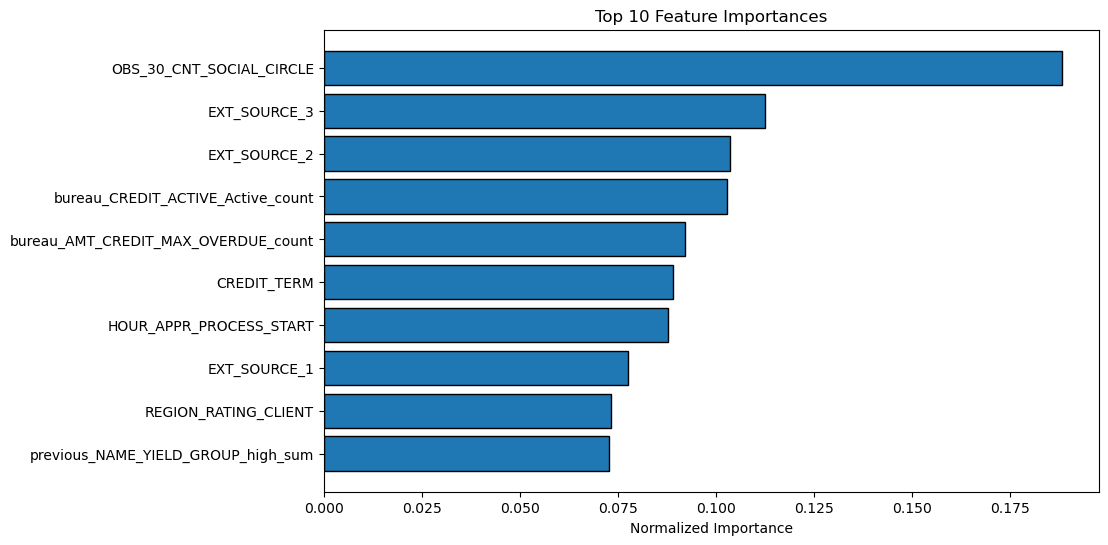

,feature,importance,importance_normalized
0,OBS_30_CNT_SOCIAL_CIRCLE,311,0.188371
1,EXT_SOURCE_3,186,0.112659
2,EXT_SOURCE_2,171,0.103574
3,bureau_CREDIT_ACTIVE_Active_count,170,0.102968
4,bureau_AMT_CREDIT_MAX_OVERDUE_count,152,0.092065
5,CREDIT_TERM,147,0.089037
6,HOUR_APPR_PROCESS_START,145,0.087826
7,EXT_SOURCE_1,128,0.077529
8,REGION_RATING_CLIENT,121,0.073289
9,previous_NAME_YIELD_GROUP_high_sum,120,0.072683


In [30]:
show_feature_importances(importances, features)

## 8.2 - Shap Values

### 8.2.1 - Interprétation globale

In [31]:
# Création de l'explainer SHAP pour le modèle LightGBM
best_model_explainer = shap.TreeExplainer(best_model_lgbm_2.named_steps['model'])

In [32]:
# Calcul des valeurs SHAP pour les données test
shap_values = best_model_explainer.shap_values(X_test_r)

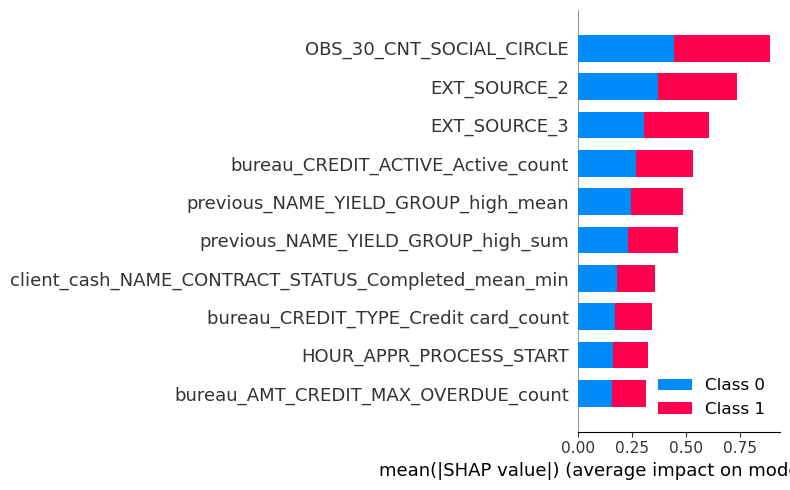

In [33]:
shap.summary_plot(best_model_explainer.shap_values(X_test_r),
                  features = X_test_r,
                  plot_type="bar",
                  feature_names=features,
                   max_display=10,
                   plot_size=(8, 5))

Si on regarde ce qui se passe pour la classe 1 :

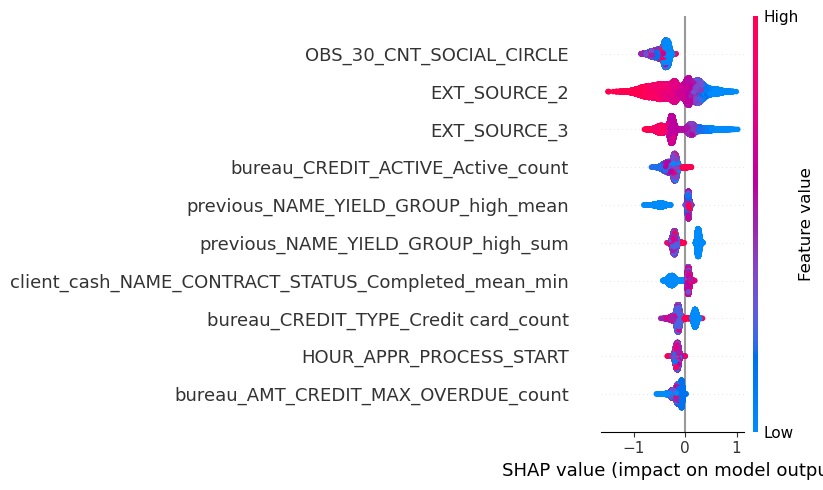

In [34]:
shap.summary_plot(best_model_explainer.shap_values(X_test_r)[1],
                  features = X_test_r,
                  feature_names=features,
                   max_display=10,
                   plot_size=(8, 5))

### 8.2.2 - Interprétation locale

In [35]:
X_test_r.head()

,CREDIT_TERM,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_EMPLOYED,DAYS_BIRTH,client_installments_AMT_PAYMENT_min_sum,AMT_ANNUITY,bureau_DAYS_CREDIT_ENDDATE_max,bureau_DAYS_CREDIT_max,...,client_bureau_balance_STATUS_1_count_norm_max,client_cash_CNT_INSTALMENT_min_min,client_bureau_balance_STATUS_X_count_min,previous_NAME_CASH_LOAN_PURPOSE_XAP_sum,client_bureau_balance_STATUS_X_count_norm_sum,client_installments_NUM_INSTALMENT_NUMBER_min_max,client_credit_AMT_INST_MIN_REGULARITY_sum_mean,OCCUPATION_TYPE_Laborers,previous_NAME_SELLER_INDUSTRY_Construction_mean,previous_NAME_CASH_LOAN_PURPOSE_XNA_sum
0,0.889266,0.705732,0.707479,0.000000,0.957459,0.327396,0.004421,0.199000,0.576120,0.955852,...,0.400000,0.126761,0.0,0.076923,0.012073,0.0,0.019179,0.0,0.0,0.017241
1,0.157447,0.444220,0.497486,0.794687,0.936300,0.410879,0.197013,0.184591,0.702708,0.899042,...,0.000000,0.000000,0.0,0.096154,0.000000,0.0,0.013419,0.0,0.0,0.120690
2,0.556254,0.547108,0.621942,0.231648,0.964326,0.587260,0.011368,0.146227,0.589233,0.863450,...,0.095238,0.098592,0.0,0.076923,0.032042,0.0,0.019179,0.0,0.0,0.051724
3,0.740962,0.524898,0.811136,0.685538,0.610205,0.684160,0.000034,0.090962,0.545527,0.252225,...,0.000000,0.154930,0.0,0.019231,0.000000,0.0,0.019179,0.0,0.0,0.000000
4,0.287297,0.683325,0.655778,0.710063,0.938310,0.723675,0.014431,0.055563,0.594982,0.925736,...,0.000000,0.014085,0.0,0.076923,0.000000,0.0,0.000000,1.0,0.0,0.086207


In [36]:
recontruct=X_test_r

In [37]:
y_test_pred_proba = best_model_lgbm_2.predict_proba(X_test_r)[:, 1]

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


In [38]:
y_test_series = pd.Series(y_test_r)
y_test_proba_series = pd.Series(y_test_pred_proba)

In [39]:
recontruct['target']=y_test_series.values
recontruct['proba']=y_test_proba_series.values
recontruct.head()

,CREDIT_TERM,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_EMPLOYED,DAYS_BIRTH,client_installments_AMT_PAYMENT_min_sum,AMT_ANNUITY,bureau_DAYS_CREDIT_ENDDATE_max,bureau_DAYS_CREDIT_max,...,client_bureau_balance_STATUS_X_count_min,previous_NAME_CASH_LOAN_PURPOSE_XAP_sum,client_bureau_balance_STATUS_X_count_norm_sum,client_installments_NUM_INSTALMENT_NUMBER_min_max,client_credit_AMT_INST_MIN_REGULARITY_sum_mean,OCCUPATION_TYPE_Laborers,previous_NAME_SELLER_INDUSTRY_Construction_mean,previous_NAME_CASH_LOAN_PURPOSE_XNA_sum,target,proba
0,0.889266,0.705732,0.707479,0.000000,0.957459,0.327396,0.004421,0.199000,0.576120,0.955852,...,0.0,0.076923,0.012073,0.0,0.019179,0.0,0.0,0.017241,False,0.154723
1,0.157447,0.444220,0.497486,0.794687,0.936300,0.410879,0.197013,0.184591,0.702708,0.899042,...,0.0,0.096154,0.000000,0.0,0.013419,0.0,0.0,0.120690,False,0.052674
2,0.556254,0.547108,0.621942,0.231648,0.964326,0.587260,0.011368,0.146227,0.589233,0.863450,...,0.0,0.076923,0.032042,0.0,0.019179,0.0,0.0,0.051724,False,0.230654
3,0.740962,0.524898,0.811136,0.685538,0.610205,0.684160,0.000034,0.090962,0.545527,0.252225,...,0.0,0.019231,0.000000,0.0,0.019179,0.0,0.0,0.000000,False,0.024183
4,0.287297,0.683325,0.655778,0.710063,0.938310,0.723675,0.014431,0.055563,0.594982,0.925736,...,0.0,0.076923,0.000000,0.0,0.000000,1.0,0.0,0.086207,False,0.075594


In [40]:
recontruct['target'].value_counts()

target
False    56554
True      4949
Name: count, dtype: int64

In [41]:
recontruct[recontruct['target']==1].head()

,CREDIT_TERM,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_EMPLOYED,DAYS_BIRTH,client_installments_AMT_PAYMENT_min_sum,AMT_ANNUITY,bureau_DAYS_CREDIT_ENDDATE_max,bureau_DAYS_CREDIT_max,...,client_bureau_balance_STATUS_X_count_min,previous_NAME_CASH_LOAN_PURPOSE_XAP_sum,client_bureau_balance_STATUS_X_count_norm_sum,client_installments_NUM_INSTALMENT_NUMBER_min_max,client_credit_AMT_INST_MIN_REGULARITY_sum_mean,OCCUPATION_TYPE_Laborers,previous_NAME_SELLER_INDUSTRY_Construction_mean,previous_NAME_CASH_LOAN_PURPOSE_XNA_sum,target,proba
10,0.287016,0.353393,0.482730,0.713783,0.984368,0.326437,0.019272,0.060302,0.587344,0.734771,...,0.125,0.057692,0.110832,0.000000,0.019179,0.0,0.0,0.000000,True,0.062977
11,0.265223,0.524898,0.529907,0.270982,0.954835,0.053495,0.018286,0.036890,0.948943,0.923682,...,0.000,0.076923,0.000000,0.000000,0.019179,1.0,0.0,0.000000,True,0.106480
24,0.263208,0.327077,0.478755,0.400258,0.956565,0.366291,0.006520,0.058547,0.669911,0.924025,...,0.000,0.019231,0.000000,0.000000,0.019179,0.0,0.0,0.051724,True,0.248649
26,0.284427,0.329541,0.421516,0.599166,0.953662,0.188670,0.007788,0.198263,0.585400,0.896988,...,0.000,0.019231,0.000000,0.000000,0.019179,1.0,0.0,0.000000,True,0.219796
40,0.556096,0.524898,0.839730,0.788042,0.961143,0.189290,0.011328,0.072166,0.569960,0.800137,...,0.000,0.038462,0.000000,0.061069,0.019179,0.0,0.0,0.000000,True,0.033142


In [42]:
# Choix de l'indice de l'individu à expliquer, par exemple le premier individu
index_to_explain = 0

# Création de l'objet Explanation pour l'individu spécifique en classe 1 
individual_shap_values_1 = shap.Explanation(
    values=shap_values[1][index_to_explain],  # Les valeurs SHAP pour la classe positive
    base_values=best_model_explainer.expected_value[1],  # La valeur de base pour la classe positive
    data=X_test_r.iloc[index_to_explain]         # Les valeurs des caractéristiques de l'individu
)

# Création de l'objet Explanation pour l'individu spécifique en classe 0
individual_shap_values_0 = shap.Explanation(
    values=shap_values[0][index_to_explain],  # Les valeurs SHAP pour la classe négative
    base_values=best_model_explainer.expected_value[0],  # La valeur de base pour la classe positive
    data=X_test_r.iloc[index_to_explain]         # Les valeurs des caractéristiques de l'individu
)


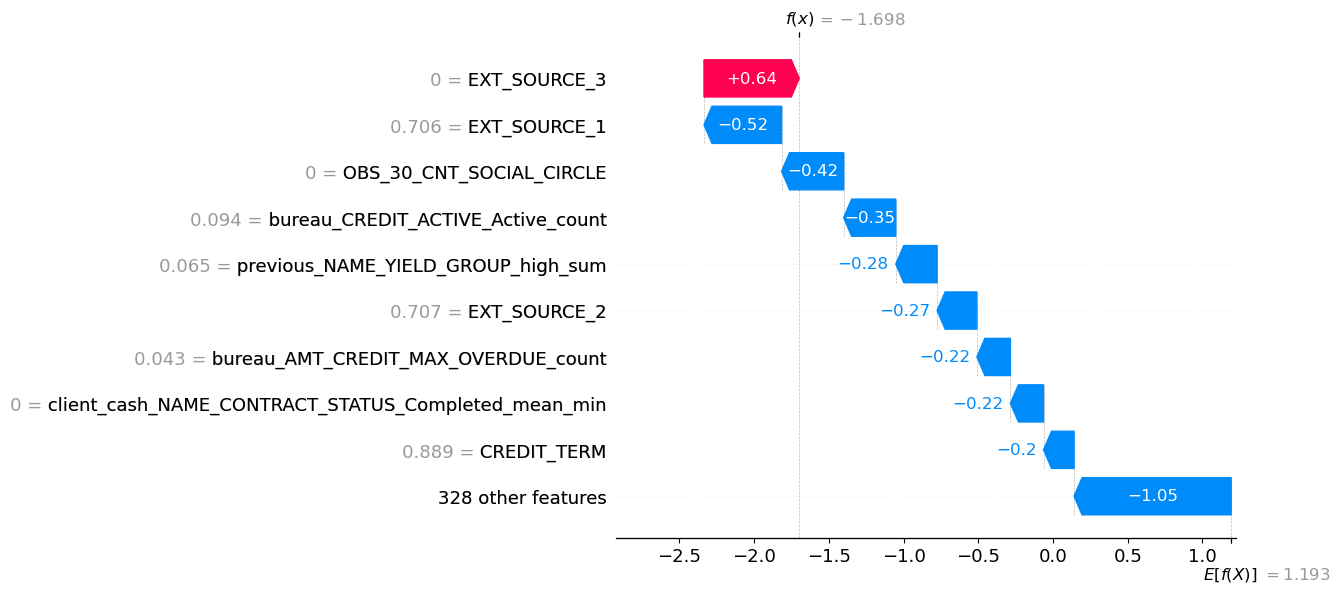

In [43]:
# Afficher le Waterfall Plot pour cet individu
shap.waterfall_plot(individual_shap_values_1)

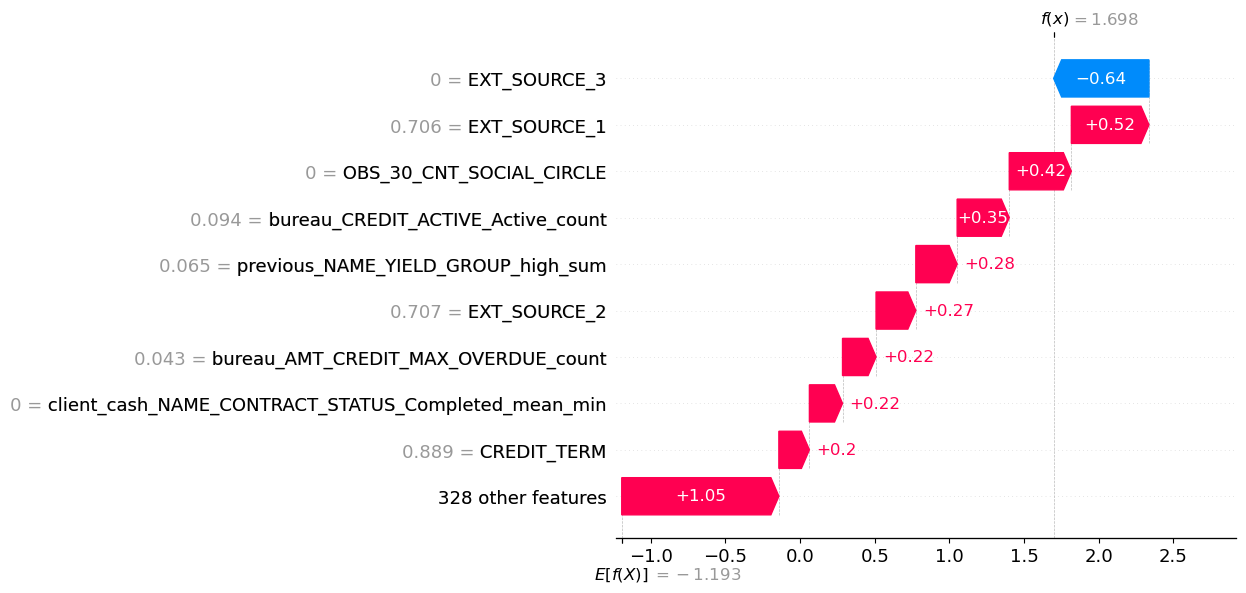

In [44]:
shap.waterfall_plot(individual_shap_values_0)

__Follow-up Notebooks__

For those looking to keep working on this problem, I have a series of follow-up notebooks:

* [Introduction to Automated Feature Engineering](https://www.kaggle.com/willkoehrsen/automated-feature-engineering-basics)
* [Advanced Automated Feature Engineering](https://www.kaggle.com/willkoehrsen/tuning-automated-feature-engineering-exploratory)
* [Feature Selection](https://www.kaggle.com/willkoehrsen/introduction-to-feature-selection)
* [Intro to Model Tuning: Grid and Random Search](https://www.kaggle.com/willkoehrsen/intro-to-model-tuning-grid-and-random-search)
* [Automated Model Tuning](https://www.kaggle.com/willkoehrsen/automated-model-tuning)
* [Model Tuning Results](https://www.kaggle.com/willkoehrsen/model-tuning-results-random-vs-bayesian-opt/notebook)




### Follow-up Notebooks

For those looking to keep working on this problem, I have a series of follow-up notebooks:

* [Manual Feature Engineering Part One](https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering)
* [Manual Feature Engineering Part Two](https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering-p2)
* [Introduction to Automated Feature Engineering](https://www.kaggle.com/willkoehrsen/automated-feature-engineering-basics)
* [Advanced Automated Feature Engineering](https://www.kaggle.com/willkoehrsen/tuning-automated-feature-engineering-exploratory)
* [Feature Selection](https://www.kaggle.com/willkoehrsen/introduction-to-feature-selection)
* [Intro to Model Tuning: Grid and Random Search](https://www.kaggle.com/willkoehrsen/intro-to-model-tuning-grid-and-random-search)

As always, I welcome feedback and constructive criticism. I write for Towards Data Science at https://medium.com/@williamkoehrsen/ and can be reached on Twitter at https://twitter.com/koehrsen_will

Will



+ faire woe ?
+ shapley
+ poids de chaque variable
+ récupération de la p value de chaque variable 
+ techniques de rééchantillonage
+ Faire courbe aucroc
+ Faire courbe Lift
+ faire taux de cible par décile